In [2]:
from pathlib import Path

import math
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import spyrit.core.meas as meas
import spyrit.core.noise as noise
import spyrit.core.prep as prep
import spyrit.core.recon as recon
import spyrit.core.nnet as nnet
import spyrit.core.train as train
import spyrit.misc.statistics as stats
import spyrit.external.drunet as drunet
from spyrit.core.recon import PinvNet


from spyrit.misc.disp import add_colorbar, noaxis
from spyrit.misc.statistics import Cov2Var
from spyrit.misc.sampling import sort_by_significance

# %% Order of measurements
def choose_pattern_order(order_name, img_size):
    # np.random.seed(seed=0)

    if order_name == 'low_freq':
        M_xy = math.ceil(M**0.5)
        Ord_rec = np.ones((img_size, img_size))

        Ord_rec[:,M_xy:] = 0
        Ord_rec[M_xy:,:] = 0

    elif order_name == 'naive':
        Ord_rec = np.ones((img_size, img_size))

    elif order_name == 'variance':
        if img_size == 128:
            cov_name = 'Cov_8_%dx%d.npy' % (img_size, img_size)
        else:
            cov_name = 'Cov_%dx%d.npy' % (img_size, img_size)

        Cov = np.load(stat_folder + cov_name)
        print(f"Cov matrix {cov_name} loaded")
        print ("the size of the cov matrix", Cov.shape)
        Ord_rec = Cov2Var(Cov)

    elif order_name == 'random':
    #     set random pixel of the Ord_rec to 1
        # Initialize a 64x64 matrix with zeros
        matrix = np.zeros((img_size, img_size), dtype=int)
        
        # Flatten the matrix to work with indices
        flat_indices = np.arange(matrix.size)  # Create an array of indices [0, 1, ..., 4095]
        
        # Randomly choose M_xy**2 unique indices to be set to 1
        M_xy = math.ceil(M**0.5)
        random_indices = np.random.choice(flat_indices, size=M_xy**2, replace=False)
        
        # Set the chosen indices to 1
        matrix.flat[random_indices] = 1
        
        # Verify the result
        print("Matrix shape:", matrix.shape)
        print("Number of elements set to 1:", np.sum(matrix))        
        Ord_rec = matrix
    elif order_name == 'random_variance':
    #     # TODO 
        # set a recontruction in high frequencies
         # Initialize a 64x64 matrix with zeros
        matrix = np.zeros((img_size, img_size), dtype=int)
         # Flatten the matrix to work with indices
        flat_indices = np.arange(matrix.size)  # Create an array of indices [0, 1, ..., 4095]
        
    elif order_name=='high_freq':
        M_xy = math.ceil(M**0.5)
        Ord_rec = np.ones((img_size, img_size))

        Ord_rec[:,:M_xy] = 0
        Ord_rec[:M_xy,:] = 0



    
    elif order_name == '70_lf':
        # M_xy = math.ceil(M**0.5)
        quad_size=int(img_size/2)
        print("quad_size",quad_size)
        first_quadrant= np.zeros((quad_size,quad_size))
        second_quadrant= np.zeros((quad_size,quad_size))
        third_quadrant= np.zeros((quad_size,quad_size))
        fourth_quadrant= np.zeros((quad_size,quad_size))
        S=first_quadrant.size
        first_ones_to_keep=int(M*0.7)
        second_ones_to_keep=int(M*0.1)
        third_ones_to_keep=int(M*0.1)
        fourth_ones_to_keep=int(M*0.1)
        indices1 = np.random.choice(S, first_ones_to_keep, replace=False)
        indices2 = np.random.choice(S, second_ones_to_keep, replace=False)
        indices3 = np.random.choice(S, third_ones_to_keep, replace=False)
        indices4 = np.random.choice(S, fourth_ones_to_keep, replace=False)
        
        # first_quadrant.flatten()[indices1]=1

        # Modify the original array using its flat iterator
        first_quadrant.flat[indices1] = 1
        second_quadrant.flat[indices2] = 1
        third_quadrant.flat[indices3] = 1
        fourth_quadrant.flat[indices4] = 1

        # Initialize the full image
        Ord_rec = np.zeros((img_size, img_size))

        Ord_rec[:quad_size,:quad_size] = first_quadrant
        Ord_rec[:quad_size,quad_size:] = second_quadrant
        Ord_rec[quad_size:,:quad_size] = third_quadrant
        Ord_rec[quad_size:,quad_size:] = fourth_quadrant

    # elif order_name == 'random_variance_3':
    #     # TODO

    else:
        print('Order name is invalid')
        exit(1)

    return Ord_rec


In [96]:
# General
# --------------------------------------------------------------------
# Experimental data
image_folder = 'data/images/'       # images for simulated measurements
model_folder = 'model/'             # reconstruction models
stat_folder  = 'stat/'              # statistics

# Full paths
image_folder_full = Path.cwd() / Path(image_folder)
model_folder_full = Path.cwd() / Path(model_folder)
stat_folder_full  = Path.cwd() / Path(stat_folder)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Loading image...
Image shape: torch.Size([1, 1, 128, 128])


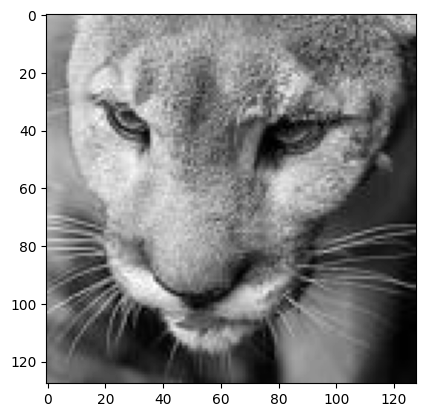

In [32]:
# Load images
# --------------------------------------------------------------------

img_size = 128 # image size

print("Loading image...")
# crop to desired size, set to black and white, normalize
transform = stats.transform_gray_norm(img_size)

# define dataset and dataloader. `image_folder_full` should contain
# a class folder with the images
dataset = torchvision.datasets.ImageFolder(
    image_folder_full, 
    transform=transform
    )

dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=10, 
    shuffle=False
    )

# select the image
x, _ = next(iter(dataloader))
x = x[1].unsqueeze(0)
b, c, h, w = x.shape
print("Image shape:", x.shape)

x_plot = x.view(-1, h, h).cpu().numpy()

plt.imshow(x_plot.squeeze(), cmap="gray")


In [5]:
# Simulate measurements for three image intensities
# --------------------------------------------------------------------
# Measurement parameters
# alpha_list = [2, 10, 50] # Poisson law parameter for noisy image acquisitions
alpha = 10 # Poisson law parameter for noisy image acquisitions

und = 4
M = img_size ** 2 // und  # Number of measurements (here, 1/4 of the pixels)

order_name = 'low_freq'
#order_name = 'naive'
#order_name = 'high_freq'
#order_name = 'variance'
#order_name = 'random'
# order_name = 'random_variance'
# order_name = 'random_variance_2'
# order_name = 'random_variance_3'


size of the variance vector (128, 128)


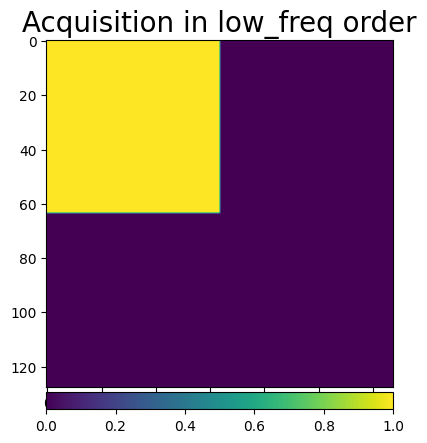

In [6]:
Ord_rec = choose_pattern_order(order_name, img_size)
count_ones= np.sum(Ord_rec)
print("number of ones in Ord_rec=",count_ones,"\nM=",(int(0.8*M)))

# Mask of order
mask_basis = np.zeros((h, h))
mask_basis.flat[:M] = 1 # M valeurs qui sont égales à 1
print("size of the variance vector",Ord_rec.shape)
mask = sort_by_significance(mask_basis, Ord_rec, axis="flatten")

im = plt.imshow(mask)
plt.title("Acquisition in " + order_name + " order", fontsize=20)
add_colorbar(im, "bottom", size="20%")

In [7]:
# Measurement and noise operators
meas_op = meas.HadamSplit(M, h, torch.from_numpy(Ord_rec))
noise_op = noise.Poisson(meas_op)
prep_op = prep.SplitPoisson(alpha, meas_op)

 
# Measurement vectors
# torch.manual_seed(0)    # for reproducibility
noise_op.alpha = alpha
print ("shape of x", x.shape)
print ("measurment operator" , meas_op.H_pinv.shape)# c'est la pseudo inverse



y = noise_op(x)

shape of x torch.Size([1, 1, 128, 128])
measurment operator torch.Size([16384, 4096])


taille de H torch.Size([4096, 16384])


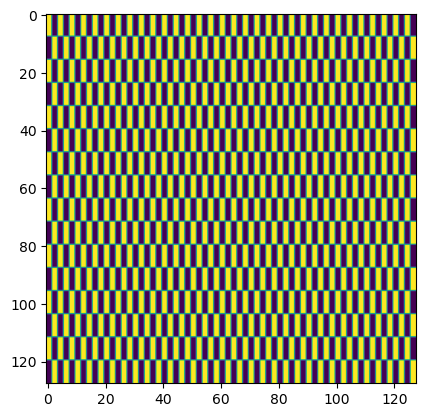

In [36]:
#
plt.imshow ( meas_op.H[1023,:].reshape(img_size, img_size))
print ("taille de H", meas_op.H.shape)

In [37]:
#training the denoiser a simple CNN





Model Loaded: model/pinv-net_unet_imagenet_N0_10_m_hadam-split_N_128_M_4096_epo_30_lr_0.001_sss_10_sdr_0.5_bs_512_reg_1e-07_retrained_light.pth


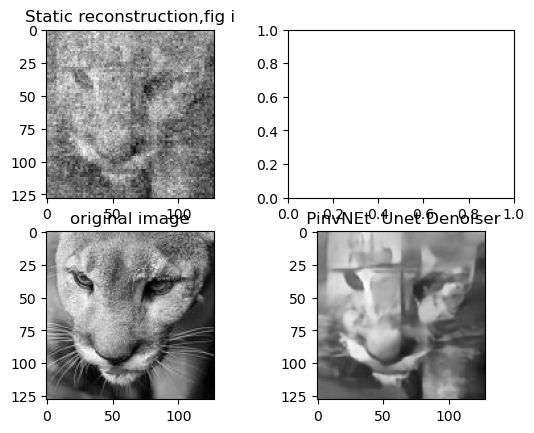

In [107]:
# %% STATIC RECO sans Pinv classe
from spyrit.core.nnet import Unet, ConvNet
from spyrit.core.train import load_net
import os

figure, axis = plt.subplots(2, 2)
with torch.no_grad():
    m = prep_op(y)
    f_stat = meas_op.pinv(m)

    axis[0,0].imshow(f_stat.view(h, w).cpu().numpy(), cmap='gray')
    axis[0,0].set_title('Static reconstruction,fig i')
    
    



# %% Reco with Pinv

"""
denoi_net_conv = ConvNet()
full_op = PinvNet ( noise_op , prep_op,denoi_net_conv )
#Load the pretrained w
with torch.no_grad():
    x_rec = full_op.reconstruct ( y )
    axis[0,1].imshow(x_rec.view(h, w).cpu().numpy(), cmap='gray')
    axis[0,1].set_title('PinvNet, no denoiser, fig j')
"""    


# %% Reco with Pinv and a Unet Denoiser
#Load the pretrained weights of the Unet

denoi_net = Unet ()
full_op = PinvNet ( noise_op , prep_op, denoi_net)
data_name = "pinv-net_unet_imagenet_N0_10_m_hadam-split_N_128_M_4096_epo_30_lr_0.001_sss_10_sdr_0.5_bs_512_reg_1e-07_retrained_light.pth"
#entrainé sur un ordre des basse freq et sur des images 128
# recontruire avec un ordre de subsampling HF et réentrainé un modèle sur ça
# prendre un peut de BF et un de 
model_unet_path = os.path.join(model_folder, data_name)
load_net(model_unet_path, full_op, device, False)
with torch.no_grad():
    
    x_rec_2 = full_op . reconstruct ( y )
    axis[1,1].imshow(x_rec_2.view(h, w).cpu().numpy(), cmap='gray')
    axis[1,1].set_title(' PinvNEt  Unet Denoiser')
    
axis[1,0].imshow(x.view(h,w).cpu().numpy(), cmap='gray')
axis[1,0].set_title('original image')
plt.show()

In [11]:
#just a test if the GPU is working
import torch

if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")

    # Simple tensor computation on GPU
    x = torch.tensor([1.0, 2.0, 3.0], device='cuda')
    y = torch.tensor([4.0, 5.0, 6.0], device='cuda')
    z = x + y
    print(f"Computation result on GPU: {z}")
else:
    print("CUDA is not available. Please check your setup.")


CUDA is available!
GPU Device: NVIDIA GeForce MX330
Computation result on GPU: tensor([5., 7., 9.], device='cuda:0')


In [ ]:
from spyrit.misc.statistics import data_loaders_stl10
from pathlib import Path

# Parameters
h = 64  # image size hxh
data_root = Path("./data_model_training")  # path to data folder (where the dataset is stored)
batch_size = 512

# Dataloader for STL-10 dataset
mode_run = True
if mode_run:
    dataloaders = data_loaders_stl10(
        data_root,
        img_size=h,
        batch_size=batch_size,
        seed=7,
        shuffle=True,
        download=True,
    )

100.0%


Extracting data_model_training/stl10_binary.tar.gz to data_model_training


In [ ]:
from spyrit.core.meas import Linear
from spyrit.core.noise import NoNoise
from spyrit.core.prep import DirectPoisson


img_size=64 # à check
h = img_size

Ord_rec = choose_pattern_order(order_name, img_size)

# Mask of order
mask_basis = np.zeros((h, h))
mask_basis.flat[:M] = 1 # M valeurs qui sont égales à 1
print("size of the variance vector",Ord_rec.shape)
mask = sort_by_significance(mask_basis, Ord_rec, axis="flatten")

im = plt.imshow(mask)
plt.title("Acquisition in " + order_name + " order", fontsize=20)
add_colorbar(im, "bottom", size="20%")

alpha = 10  # Mean maximum total number of photons

meas_op = meas.HadamSplit(M, h, torch.from_numpy(Ord_rec))
noise_op = noise.Poisson(meas_op)
prep_op = prep.SplitPoisson(alpha, meas_op)

In [ ]:
from spyrit.core.nnet import ConvNet
from spyrit.core.recon import PinvNet

denoiser = ConvNet()
model = PinvNet(noise_op, prep_op, denoi=denoiser)

# Send to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Use multiple GPUs if available
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from spyrit.core.train import save_net, Weight_Decay_Loss

# Parameters
lr = 1e-3
step_size = 10
gamma = 0.5

loss = nn.MSELoss()
criterion = Weight_Decay_Loss(loss)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)# We train for one epoch only to check that everything works fine.

from spyrit.core.train import train_model
from datetime import datetime

# Parameters
model_root = Path("./model")  # path to model saving files
num_epochs = 5  # number of training epochs (num_epochs = 30)
checkpoint_interval = 2  # interval between saving model checkpoints
tb_freq = (
    50  # interval between logging to Tensorboard (iterations through the dataloader)
)

# Path for Tensorboard experiment tracking logs
name_run = "stdl10_hadampos"
now = datetime.now().strftime("%Y-%m-%d_%H-%M")
tb_path = f"runs/runs_{name_run}_n{int(N0)}_m{M}/{now}"

# Train the network
if mode_run:
    model, train_info = train_model(
        model,
        criterion,
        optimizer,
        scheduler,
        dataloaders,
        device,
        model_root,
        num_epochs=num_epochs,
        disp=True,
        do_checkpoint=checkpoint_interval,
        tb_path=tb_path,
        tb_freq=tb_freq,
    )
else:
    train_info = {}

In [ ]:
from spyrit.core.train import save_net

# Training parameters
train_type = "N0_{:g}".format(N0)
arch = "pinv-net"
denoi = "cnn"
data = "stl10"
reg = 1e-7  # Default value
suffix = "N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}".format(
    h, M, num_epochs, lr, step_size, gamma, batch_size
)
title = model_root / f"{arch}_{denoi}_{data}_{train_type}_{suffix}"
print(title)

Path(model_root).mkdir(parents=True, exist_ok=True)

if checkpoint_interval:
    Path(title).mkdir(parents=True, exist_ok=True)

save_net(str(title) + ".pth", model)

# Save training history
import pickle

if mode_run:
    from spyrit.core.train import Train_par

    params = Train_par(batch_size, lr, h, reg=reg)
    params.set_loss(train_info)

    train_path = model_root / f"TRAIN_{arch}_{denoi}_{data}_{train_type}_{suffix}.pkl"

    with open(train_path, "wb") as param_file:
        pickle.dump(params, param_file)
    torch.cuda.empty_cache()

else:
    from spyrit.misc.load_data import download_girder

    url = "https://tomoradio-warehouse.creatis.insa-lyon.fr/api/v1"
    dataID = "667ebfe4baa5a90007058964"  # unique ID of the file
    data_name = "tuto4_TRAIN_pinv-net_cnn_stl10_N0_1_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_512_reg_1e-07.pkl"
    train_path = os.path.join(model_root, data_name)
    # download girder file
    download_girder(url, dataID, model_root, data_name)

    with open(train_path, "rb") as param_file:
        params = pickle.load(param_file)
    train_info["train"] = params.train_loss
    train_info["val"] = params.val_loss

In [ ]:


# Plot
# sphinx_gallery_thumbnail_number = 2

fig = plt.figure()
plt.plot(train_info["train"], label="train")
plt.plot(train_info["val"], label="val")
plt.xlabel("Epochs", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend(fontsize=20)
plt.show()

